In [1]:
# some packages to install
# %pip install statsmodels scipy matplotlib numpy pandas seaborn scikit-learn

# Sample size calculation

Function to compute the sample size & some analyses to play around.

In [2]:
# Some imports, ignore this
import statsmodels.api as sm
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

*The* function to compute the sample size, this piece of code we should iterate: 

In [3]:
def wilson_sample_size_needed_with_prevalence(sensitivity, prevalence, confidence_level, wilson_lower_limit, discard_rate):
    """
    Parameters:
    sensitivity      : Desired sensitivity of the test.
    prevalence       : Prevalence of the condition in the population.
    confidence_level : Desired confidence level.
    width            : Lower limit of the confidence interval.

    Returns:
    tuple: 
        - int: Estimated minimum sample size required for the total population.
        - int: Expected number of useful positive cases, based on sensitivity and prevalence.
    """
    z = norm.ppf((1 + confidence_level) / 2)  # Z-value for the specified confidence level
    n = 10  # Very low initial guess for the number of total participants

    while True:
        n += 1 # Increase the sample size by 1
        effective_sample_size = int(n * (1 - discard_rate))  # Adjust sample size for expected discards
        expected_positives = int(effective_sample_size * prevalence) # Calculate the expected number of positive cases taking the prevalence into account
        
        if expected_positives == 0: 
            continue  # Skip if there are no expected positive cases 
        
        # Calculate the Wilson score interval for the expected number of positive cases
        interval = sm.stats.proportion_confint(int(expected_positives * sensitivity), 
                                               int(expected_positives), 
                                               alpha= 1-confidence_level, 
                                               method='wilson')
        
        # Check if the lower limit of the interval is greater than the desired lower limit
        if interval[0] > wilson_lower_limit:
            break

        if n > 50000: 
            raise ValueError("Sample size is too large. Please check your input values.")

    useful_positives = int(n * prevalence * sensitivity)  # Calculate the expected number of useful positive cases
    return n, useful_positives


## Playing around with the parameters

Some parameters, taken from the analyzed documents:

In [4]:
desired_sensitivity = 0.97
prevalence = 0.10
desired_confidence_level = 0.95
wilson_ci_lower_limit = 0.90
discard_rate = 0.00

We call the function:

In [5]:
total_sample_size, useful_positive_cases = wilson_sample_size_needed_with_prevalence(desired_sensitivity, 
                                                                                     prevalence, 
                                                                                     desired_confidence_level, 
                                                                                     wilson_ci_lower_limit, 
                                                                                     discard_rate)

In [6]:
# We print the results
print(f"Estimated minimum total sample size needed: {total_sample_size}")
print(f"Expected number of useful positive cases: {useful_positive_cases}")

Estimated minimum total sample size needed: 840
Expected number of useful positive cases: 81


As you can see, the obtained numbers are *around* the once you computed, but not the same ones.  

## Adding 10% discards

Same as before but considering discarded data

In [7]:
discard_rate = 0.10

In [8]:
total_sample_size, useful_positive_cases = wilson_sample_size_needed_with_prevalence(desired_sensitivity, 
                                                                                     prevalence, 
                                                                                     desired_confidence_level, 
                                                                                     wilson_ci_lower_limit, 
                                                                                     discard_rate)

In [9]:
print(f"Estimated minimum total sample size needed: {total_sample_size}")
print(f"Expected number of useful positive cases: {useful_positive_cases}")

Estimated minimum total sample size needed: 934
Expected number of useful positive cases: 90


Again, similar numbers but not the same ones you computed. 

## Considering risks & benefits

In order to consider how the sample size changes depending on being applied before of after cell inspection (the mentioned 30%), the function is the same one, the only thing to change is the prevalence (i.e. 30% benefited with the dx of the 10% prevalence = 3% "final" prevalence). 

In [10]:
# Standard values
desired_sensitivity = 0.97
prevalence = 0.10
desired_confidence_level = 0.95
wilson_ci_lower_limit = 0.90
discard_rate = 0.10

In [11]:
sample_sizes = []
useful_positives = []
for p in range(9,101):
    final_prevalence = prevalence * (p/100)

    total_sample_size, useful_positive_cases = wilson_sample_size_needed_with_prevalence(desired_sensitivity, 
                                                                                         final_prevalence, 
                                                                                         desired_confidence_level, 
                                                                                         wilson_ci_lower_limit, 
                                                                                         discard_rate)

    sample_sizes.append(total_sample_size)
    useful_positives.append(useful_positive_cases)


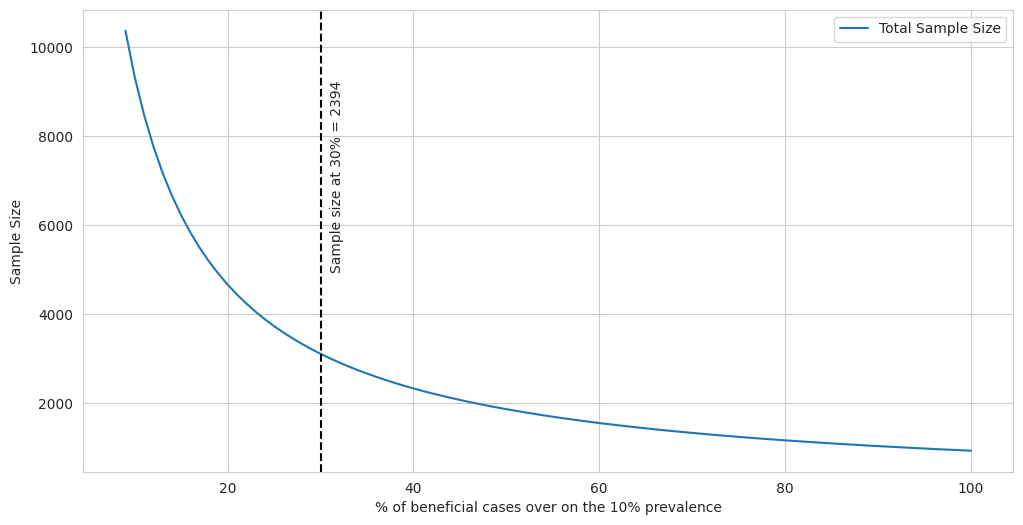

In [20]:
# Plot the results
sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))
plt.plot(range(9,101), sample_sizes, label="Total Sample Size")
plt.xlabel("% of beneficial cases over on the 10% prevalence")
plt.ylabel("Sample Size")

# At 30 add a vertical line and a label indicating y value
plt.axvline(30, color='k', linestyle='--')
plt.text(31, 5000, f'Sample size at 30% = {sample_sizes[30]}', rotation=90)

plt.legend()
plt.show()